In [ ]:
'''
Batch running
'''

In [18]:
'''
Packages
'''
from model import *
import csv
from mesa.batchrunner import BatchRunner
import pandas as pd
import numpy as np
import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
initialhouses = [50, 100, 150, 200]
rentalcost = 2000
initialhouseholds = 2000 
steps = 100

In [ ]:
'''
Ginicoefficient distribution
'''

initialhouses = 200
rentalcost = 2000
initialhouseholds = 2000 
steps = 100

agent_data = []
model_data = []

for i in tqdm.tqdm(range(30)):   
    model = HousingMarket(rental_cost = rentalcost, initial_houses = initialhouses, initial_households = initialhouseholds)
    model.run_model(steps)
    
    da = model.datacollector.get_agent_vars_dataframe()
    dm = model.datacollector.get_model_vars_dataframe()
    
    agent_data.append(da)
    model_data.append(dm)

In [ ]:
gini = []

for i in range(len(model_data)):
    gini.append(model_data[i]["Gini"].iloc[-1])

In [ ]:
sns.histplot(data = gini)

In [19]:
'''
Sensitivity analysis: OFAT - Rent cost
'''

# Initial Conditions
initialhouses = 500
initialhouseholds = 2000 
steps = 100
rentcost = [750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000]
iterations = 30
steps = 50

In [20]:
agent_data = {}
model_data = {}

for i in tqdm.tqdm(range(len(rentcost))):   
    for j in range(iterations):
        model = HousingMarket(rental_cost = rentcost[i], initial_houses = initialhouses, initial_households = initialhouseholds)
        model.run_model(steps)

        da = model.datacollector.get_agent_vars_dataframe()
        dm = model.datacollector.get_model_vars_dataframe()

        agent_data[i,j] = da
        model_data[i,j] = dm

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [21:34<00:00, 129.47s/it]


In [21]:
stats_data = {}

for i in range(len(rentcost)):
    temp = []
    
    for j in range(iterations):
        temp.append(model_data[i,j]["Gini"].iloc[-1])
    
    stats_data[rentcost[i]] = [np.mean(temp), np.std(temp)]

In [22]:
y = []
yvar = []
err = []
for x in stats_data.items():
    y.append(x[1][0])
    yvar.append(x[1][1])
    err = 1.96 * x[1][1] / np.sqrt(3)

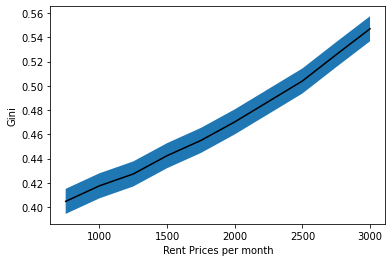

In [24]:
'''
Plot shit
'''

x = stats_data.keys()
plt.plot(x, y, c = 'k')
plt.fill_between(x, y - err, y + err)
plt.xlabel("Rent Prices per month")
plt.ylabel("Gini")
plt.show()

In [ ]:
'''
Local Sensitivy analysis:

Household: saving_lower, savings_upper, income_lower, income_upper, price, rental_cost
House: price, price_lower, price_upper, inital_houses, inital_households
'''

In [1]:
'''
Packages
'''
from model import *
import csv
from mesa.batchrunner import BatchRunner
import pandas as pd
import numpy as np
import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import time

In [80]:
'''
Initial Conditions
'''
initial_houses = 20
initial_households = 30
rental_cost = 1000
savings_lower = 0
savings_upper = 50_000
price_lower = 10_000
price_upper = 100_000

'''
Define model run
'''
samples = 4
max_steps = 20
ofat_size = 5

In [81]:
#saving_lower, savings_upper, income_lower, income_upper, price_lower, price_upper, rental_cost

problem = {
    'names': ['savings_lower', 'savings_upper', 'income_lower', 'income_upper', 'price_lower', 'price_upper', 'rental_cost'],
    'bounds': [[10, 100], [11, 100], [11, 100], [12, 100], [12,100], [13,100], [13,100]]
    
}

In [82]:
# Using dict
data_experiment = {}

for i, var in enumerate(problem['names']):
    # Iterate over parameters    
    parameter = var
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    

    for j in variable_values:
        # Iterate over bounds of parameter
            
        for k in range(samples):
            # Iterate over sample size to apply clt
                        
            model = HousingMarket(parameter := int(j))
            model.run_model(max_steps)
            data = model.datacollector.get_model_vars_dataframe()
            data_experiment[var, j, k] = data['Gini'].iloc[-1]         

In [83]:
# Using Pandas dataframe
df_experiment = pd.DataFrame(columns = ('Variable', 'Parameter', 'Gini'))

for i, var in enumerate(problem['names']):
    # Iterate over parameters    
    parameter = var
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    

    for j in variable_values:
        # Iterate over bounds of parameter
            
        for k in range(samples):
            # Iterate over sample size to apply clt
                        
            model = HousingMarket(parameter := int(j))
            model.run_model(max_steps)
            data = model.datacollector.get_model_vars_dataframe()
            
            dict = {'Variable': var, 'Parameter': j, 'Gini': data['Gini'].iloc[-1]}
            df_experiment = df_experiment.append(dict, ignore_index=True)
            
test = df_experiment
test = test.set_index(['Variable', 'Parameter'])

In [84]:
temp = {}
for i, var in enumerate(problem['names']):
    parameter = var
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    
    for j in variable_values:
        temp[var, j] = [test.loc[var, j].mean()[0], test.loc[var, j].std()[0]]
        


C:\Users\sebas\AppData\Local\Temp/ipykernel_13652/2332671536.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp[var, j] = [test.loc[var, j].mean()[0], test.loc[var, j].std()[0]]


C:\Users\sebas\AppData\Local\Temp/ipykernel_13652/2778463906.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  y.append(test.loc[var, j].mean()[0])
C:\Users\sebas\AppData\Local\Temp/ipykernel_13652/2778463906.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  err.append(test.loc[var, j].std()[0])
C:\Users\sebas\AppData\Local\Temp/ipykernel_13652/2778463906.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  y.append(test.loc[var, j].mean()[0])
C:\Users\sebas\AppData\Local\Temp/ipykernel_13652/2778463906.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  err.append(test.loc[var, j].std()[0])
C:\Users\sebas\AppData\Local\Temp/ipykernel_13652/2778463906.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  y.append(test.loc[var, j].mean()[0])
C:\Users\sebas\AppData\Local\Temp/ipykernel_13652/2778463906.py:17: PerformanceWarning: indexing past l

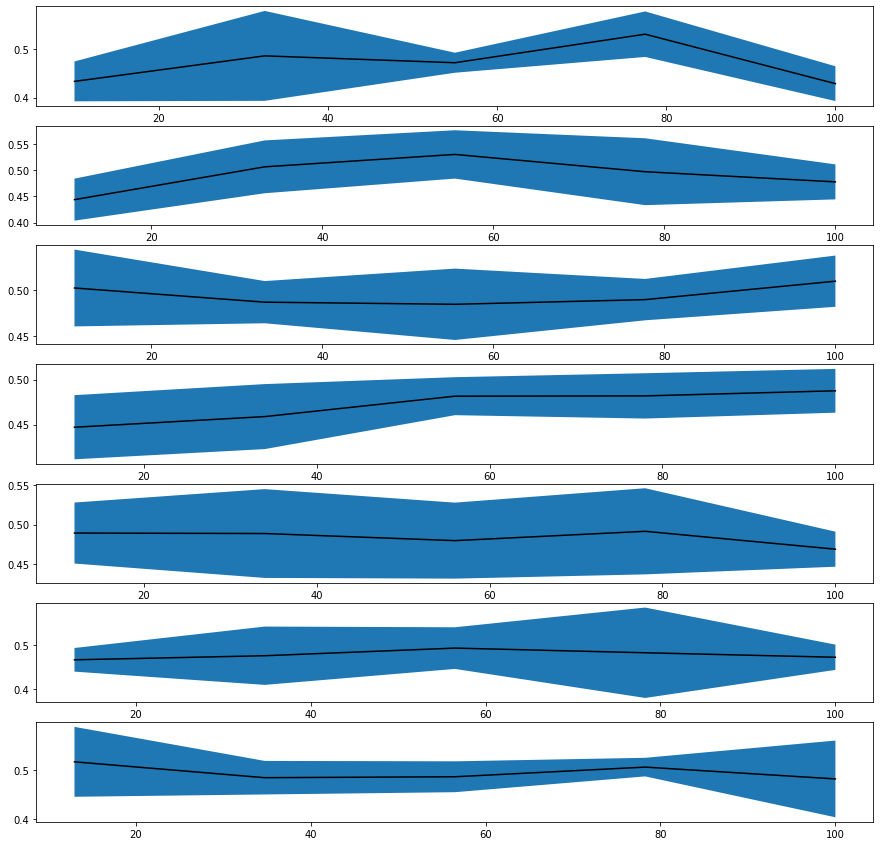

In [86]:
# Data
fig, axs = plt.subplots(len(problem['names']), figsize = (15,15))



for i, var in enumerate(problem['names']):
    
    y = []
    err = []
    
    parameter = var
    x = np.linspace(*problem['bounds'][i], ofat_size)

    
    for j in x:
        y.append(test.loc[var, j].mean()[0])
        err.append(test.loc[var, j].std()[0])
    
    axs[i].plot(x, y, c = 'k')
    axs[i].fill_between(x, np.array(y) - np.array(err), np.array(y) + np.array(err)) 